In [14]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix,average_precision_score,roc_curve
from sklearn.model_selection import StratifiedKFold,GridSearchCV
from data_treat.get_ready_data import get_data
from data_treat.data_normalizer import CustomNormalizer
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.metrics import roc_auc_score


In [15]:
COLUMNS = ["distance_from_home","distance_from_last_transaction","ratio_to_median_purchase_price",
           "repeat_retailer","used_chip","used_pin_number","online_order","fraud"]

In [16]:
def feture_importants(importantance):
    res = ''
    for ind, imp in enumerate(importantance):
        res += f"{COLUMNS[ind]} :  {imp}\n"

    return res

In [17]:
data = get_data()

In [18]:
target_variable_name = 'fraud'
labels = data[target_variable_name]
data = data.drop(target_variable_name, axis=1)

In [19]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=.20,random_state=42)

In [20]:
#Создаём функцию для подбора лучших параметров модели
def model_func(x_train, x_test):
    def gridSearch(X,y):

        param_dict = {
        "criterion": ['gini', 'entropy'],
        "max_depth" : np.arange(1,10,2),
        "splitter": ['best', 'random'],
        }
        model = DecisionTreeClassifier(random_state=42)
        gv = GridSearchCV(model,param_grid=param_dict,cv=10)
        gv.fit(X,y)
        return gv.best_score_,gv.best_params_


    #Ищем лучшие параметры
    params = gridSearch(x_train,y_train)
    print(params)

    #Строим саму модель
    model = DecisionTreeClassifier(random_state=42,
                                criterion = params[1]["criterion"],
                                max_depth =  params[1]["max_depth"],
                                splitter =  params[1]["splitter"])

    #Обучаем
    model.fit(x_train,y_train)
    prediction = model.predict(x_test)

    #Выводим оценку точности
    print ("Accuracy : ",accuracy_score(y_test,prediction)*100)
    print(classification_report(y_test, prediction))

    #Выводим матрицу ошибок
    print(confusion_matrix(y_test, prediction))

    #Получаем уверенность модели для всех предсказаний    
    test_probabilities = model.predict_proba(x_test)
    test_probabilities = test_probabilities[:, 1]
    false_positive_rates, true_positive_rates, threshold = roc_curve(y_test, test_probabilities)

    #строим ROC-AUC кривую
    plt.figure(figsize=(7, 7))

    # рисуем кривую
    plt.plot(false_positive_rates, true_positive_rates, label='Сглаженные значения ROC-AUC')

    # кривая, соответствующая случайному угадыванию
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle=':', label='Модель, выдающая случайное значение')

    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.fill_between(false_positive_rates, true_positive_rates, step="mid", alpha=0.4, label='площадь под кривой (ROC-AUC)')
    plt.legend()
    plt.show()

    #Получаем значениие площади под кривой для тестовой выборки
    roc_auc_value = roc_auc_score(y_test, test_probabilities)

    print("ROC-AUC на тестовой выборке:", roc_auc_value)


    print(feture_importants(model.feature_importances_))
    plt.figure(figsize=(30,30))  # set plot size (denoted in inches)
    tree.plot_tree(model,feature_names=COLUMNS,fontsize=10)
    plt.show()

Для сырых данных

(0.9999213432747902, {'criterion': 'gini', 'max_depth': 7, 'splitter': 'best'})
Accuracy :  99.99141925519135
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     17545
         1.0       1.00      1.00      1.00     17417

    accuracy                           1.00     34962
   macro avg       1.00      1.00      1.00     34962
weighted avg       1.00      1.00      1.00     34962

[[17545     0]
 [    3 17414]]


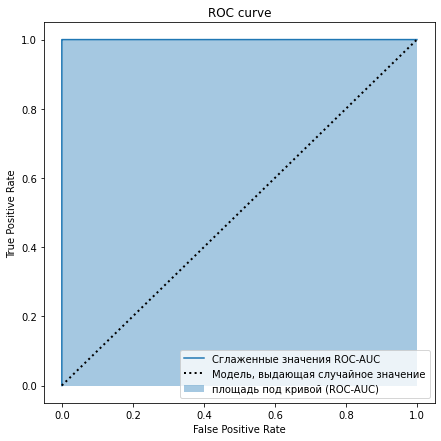

ROC-AUC на тестовой выборке: 0.9999712924154562
distance_from_home :  0.2757814076173848
distance_from_last_transaction :  0.11172223112706761
ratio_to_median_purchase_price :  0.5152142882343009
repeat_retailer :  0.002940840561314908
used_chip :  0.022351632333142576
used_pin_number :  0.01730572702007957
online_order :  0.054683873106709656



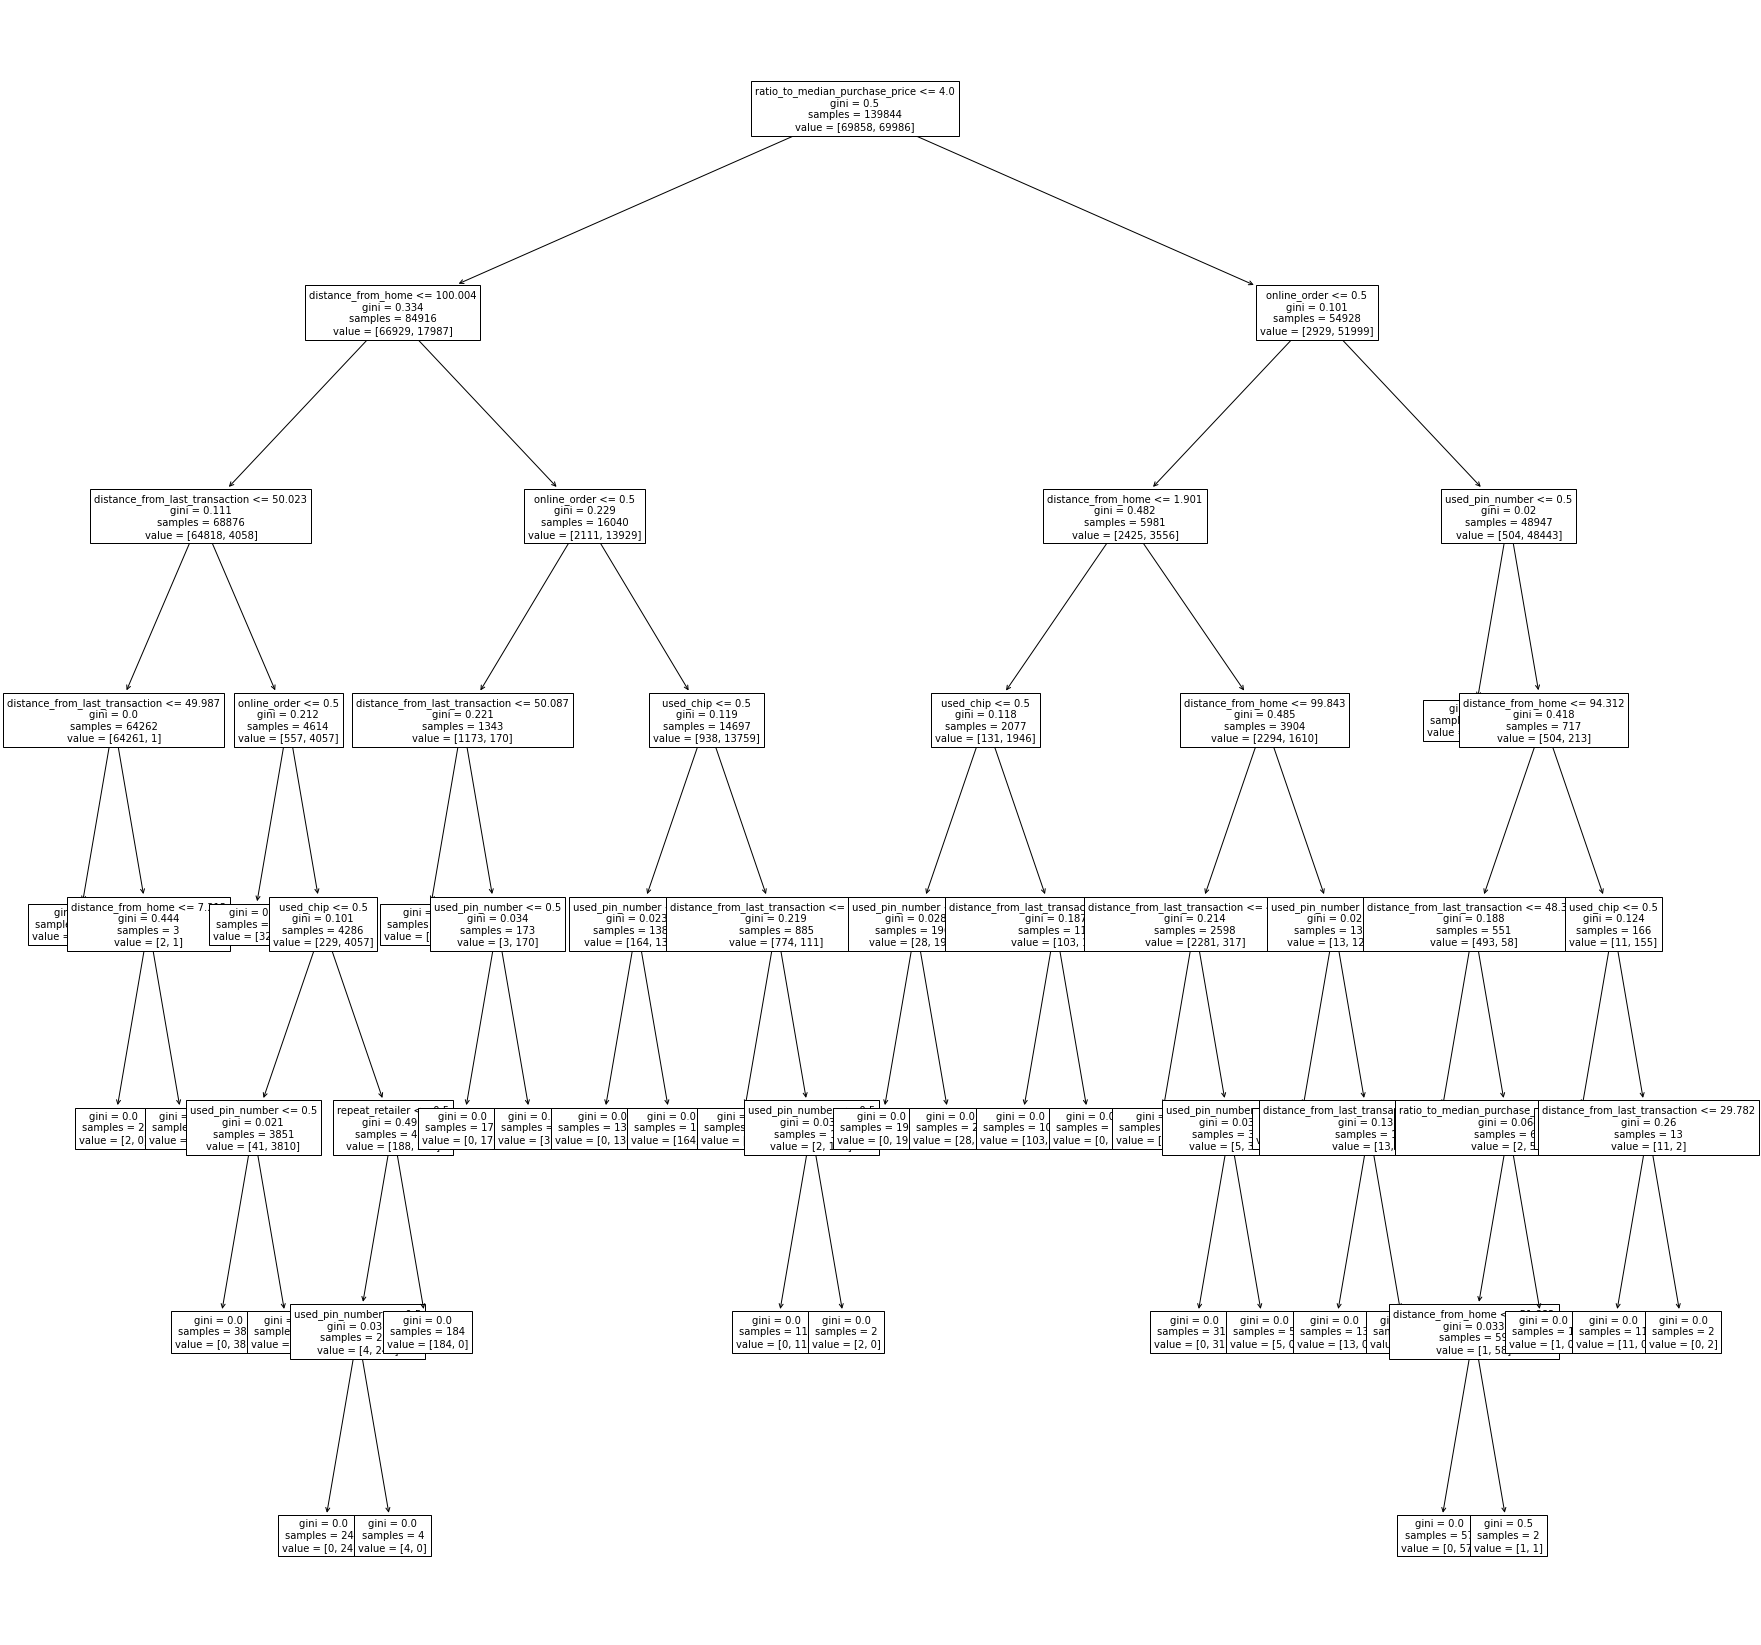

In [21]:
model_func(x_train, x_test)

Для нормализированных данных

(0.9999213432747902, {'criterion': 'gini', 'max_depth': 7, 'splitter': 'best'})
Accuracy :  85.09524626737601
              precision    recall  f1-score   support

         0.0       0.87      0.82      0.85     17545
         1.0       0.83      0.88      0.85     17417

    accuracy                           0.85     34962
   macro avg       0.85      0.85      0.85     34962
weighted avg       0.85      0.85      0.85     34962

[[14456  3089]
 [ 2122 15295]]


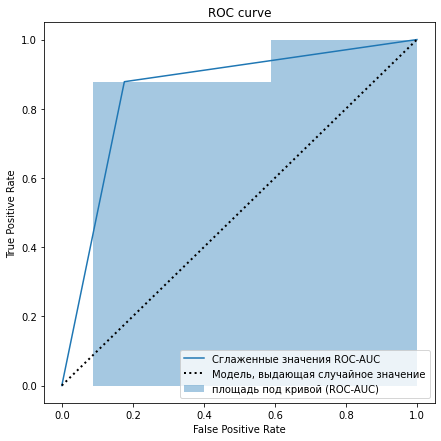

ROC-AUC на тестовой выборке: 0.8510753808810889
distance_from_home :  0.2757814076173848
distance_from_last_transaction :  0.11172223112706761
ratio_to_median_purchase_price :  0.5152142882343009
repeat_retailer :  0.002940840561314908
used_chip :  0.022351632333142576
used_pin_number :  0.01730572702007957
online_order :  0.054683873106709656



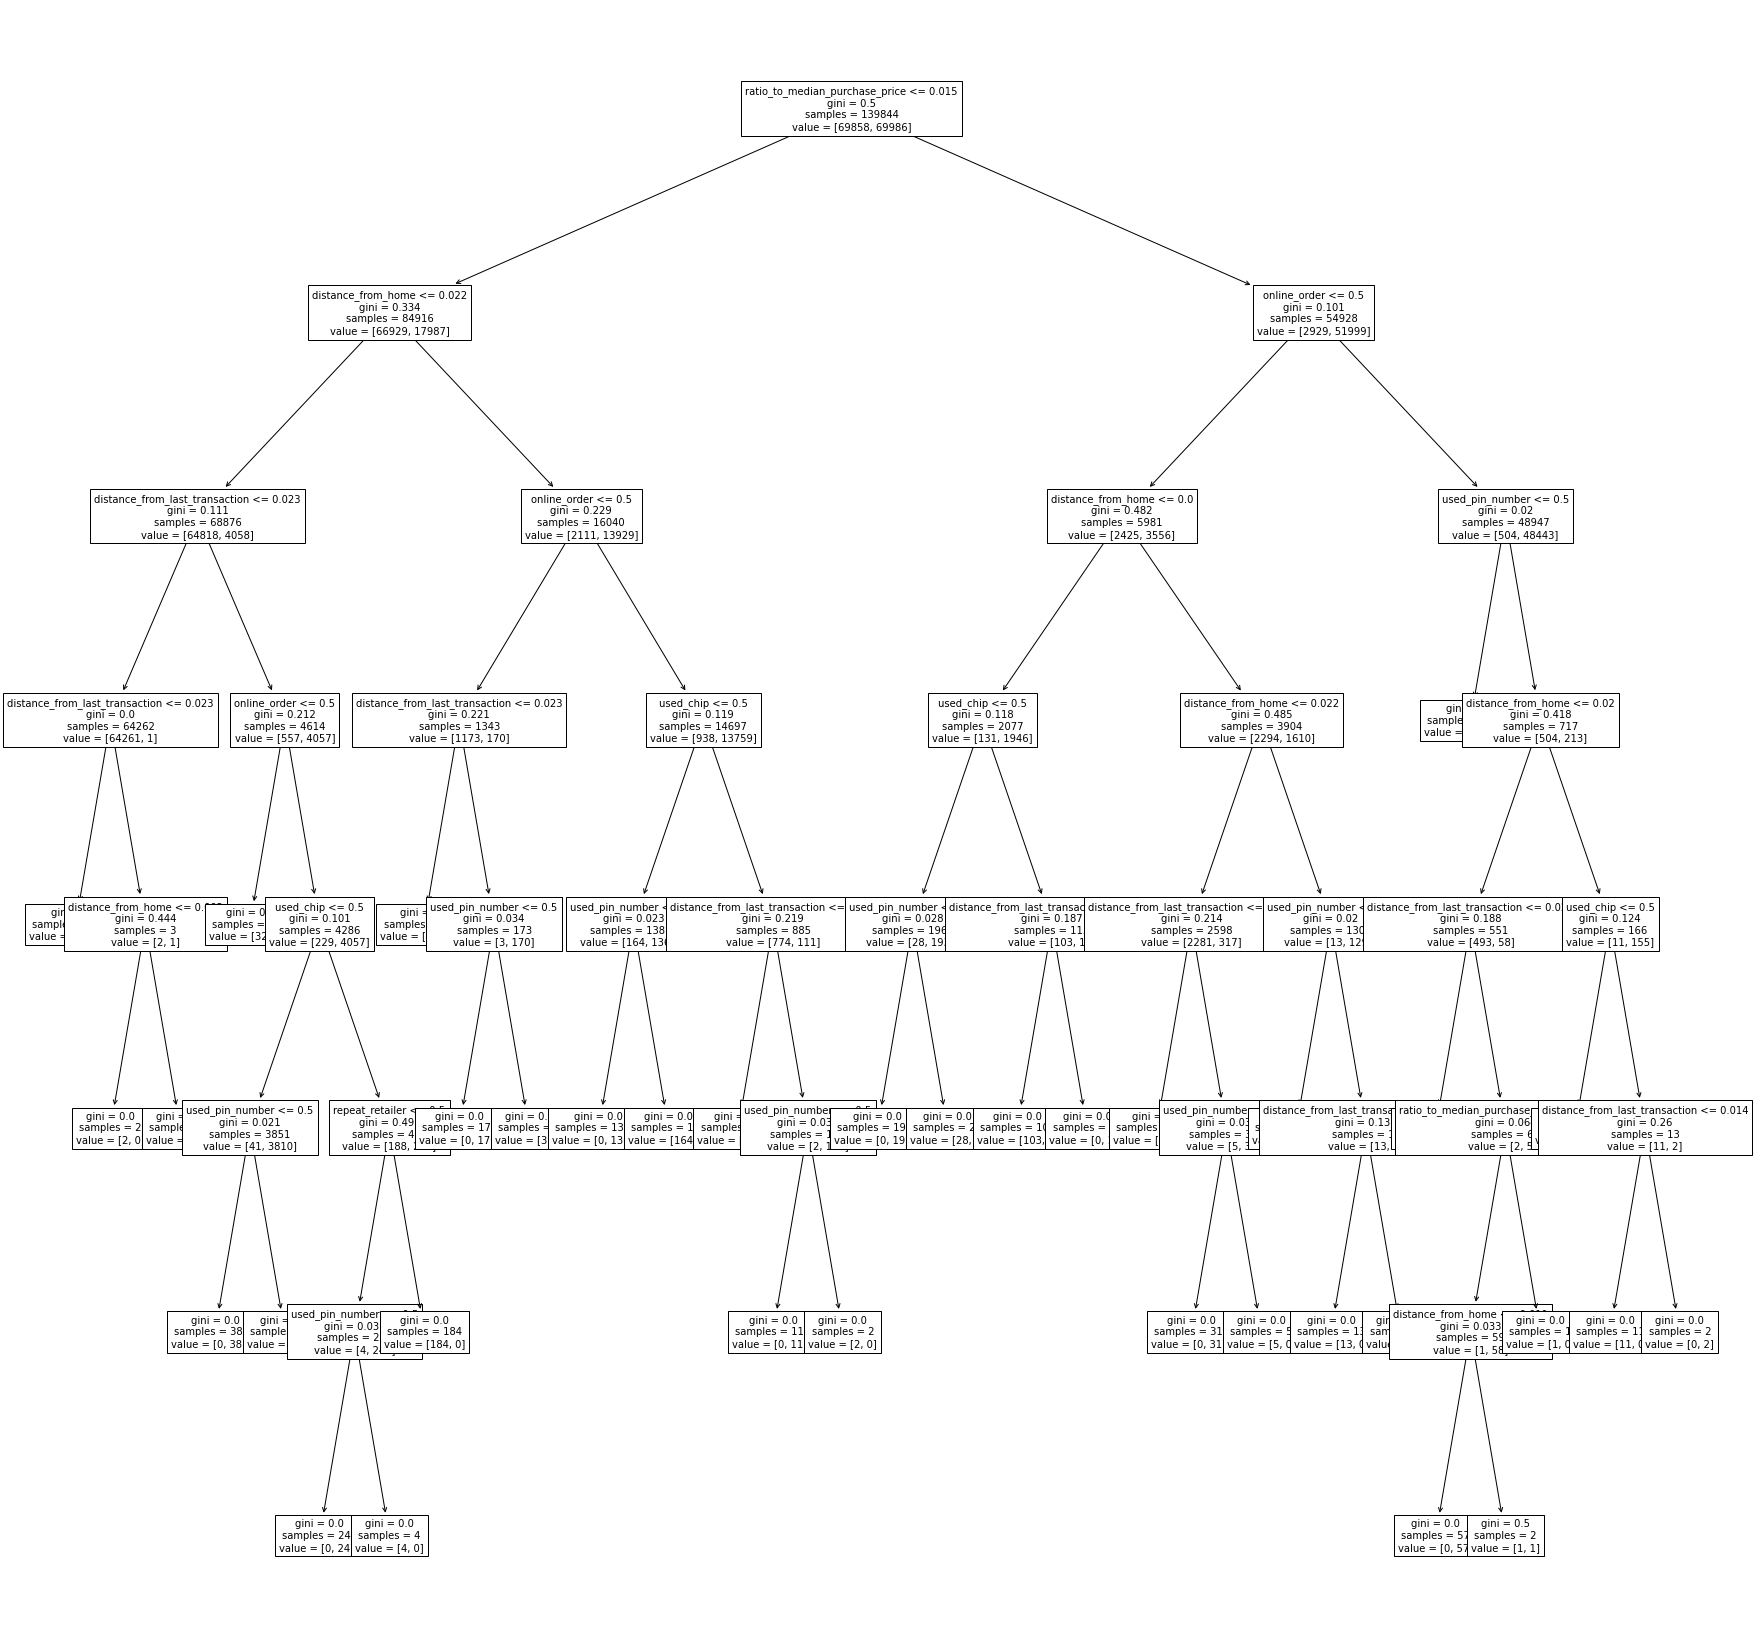

In [22]:
model_func(CustomNormalizer.normalize(x_train), CustomNormalizer.normalize(x_test))

Для Стандартизированных данных

(0.9999213432747902, {'criterion': 'gini', 'max_depth': 7, 'splitter': 'best'})
Accuracy :  96.92523311023396
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     17545
         1.0       1.00      0.94      0.97     17417

    accuracy                           0.97     34962
   macro avg       0.97      0.97      0.97     34962
weighted avg       0.97      0.97      0.97     34962

[[17509    36]
 [ 1039 16378]]


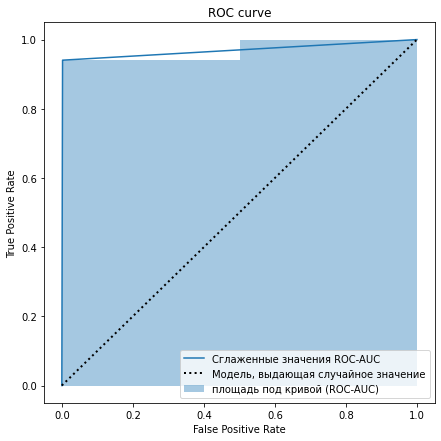

ROC-AUC на тестовой выборке: 0.9692041837054375
distance_from_home :  0.2757814076173848
distance_from_last_transaction :  0.11172223112706761
ratio_to_median_purchase_price :  0.5152142882343009
repeat_retailer :  0.002940840561314908
used_chip :  0.022351632333142576
used_pin_number :  0.01730572702007957
online_order :  0.054683873106709656



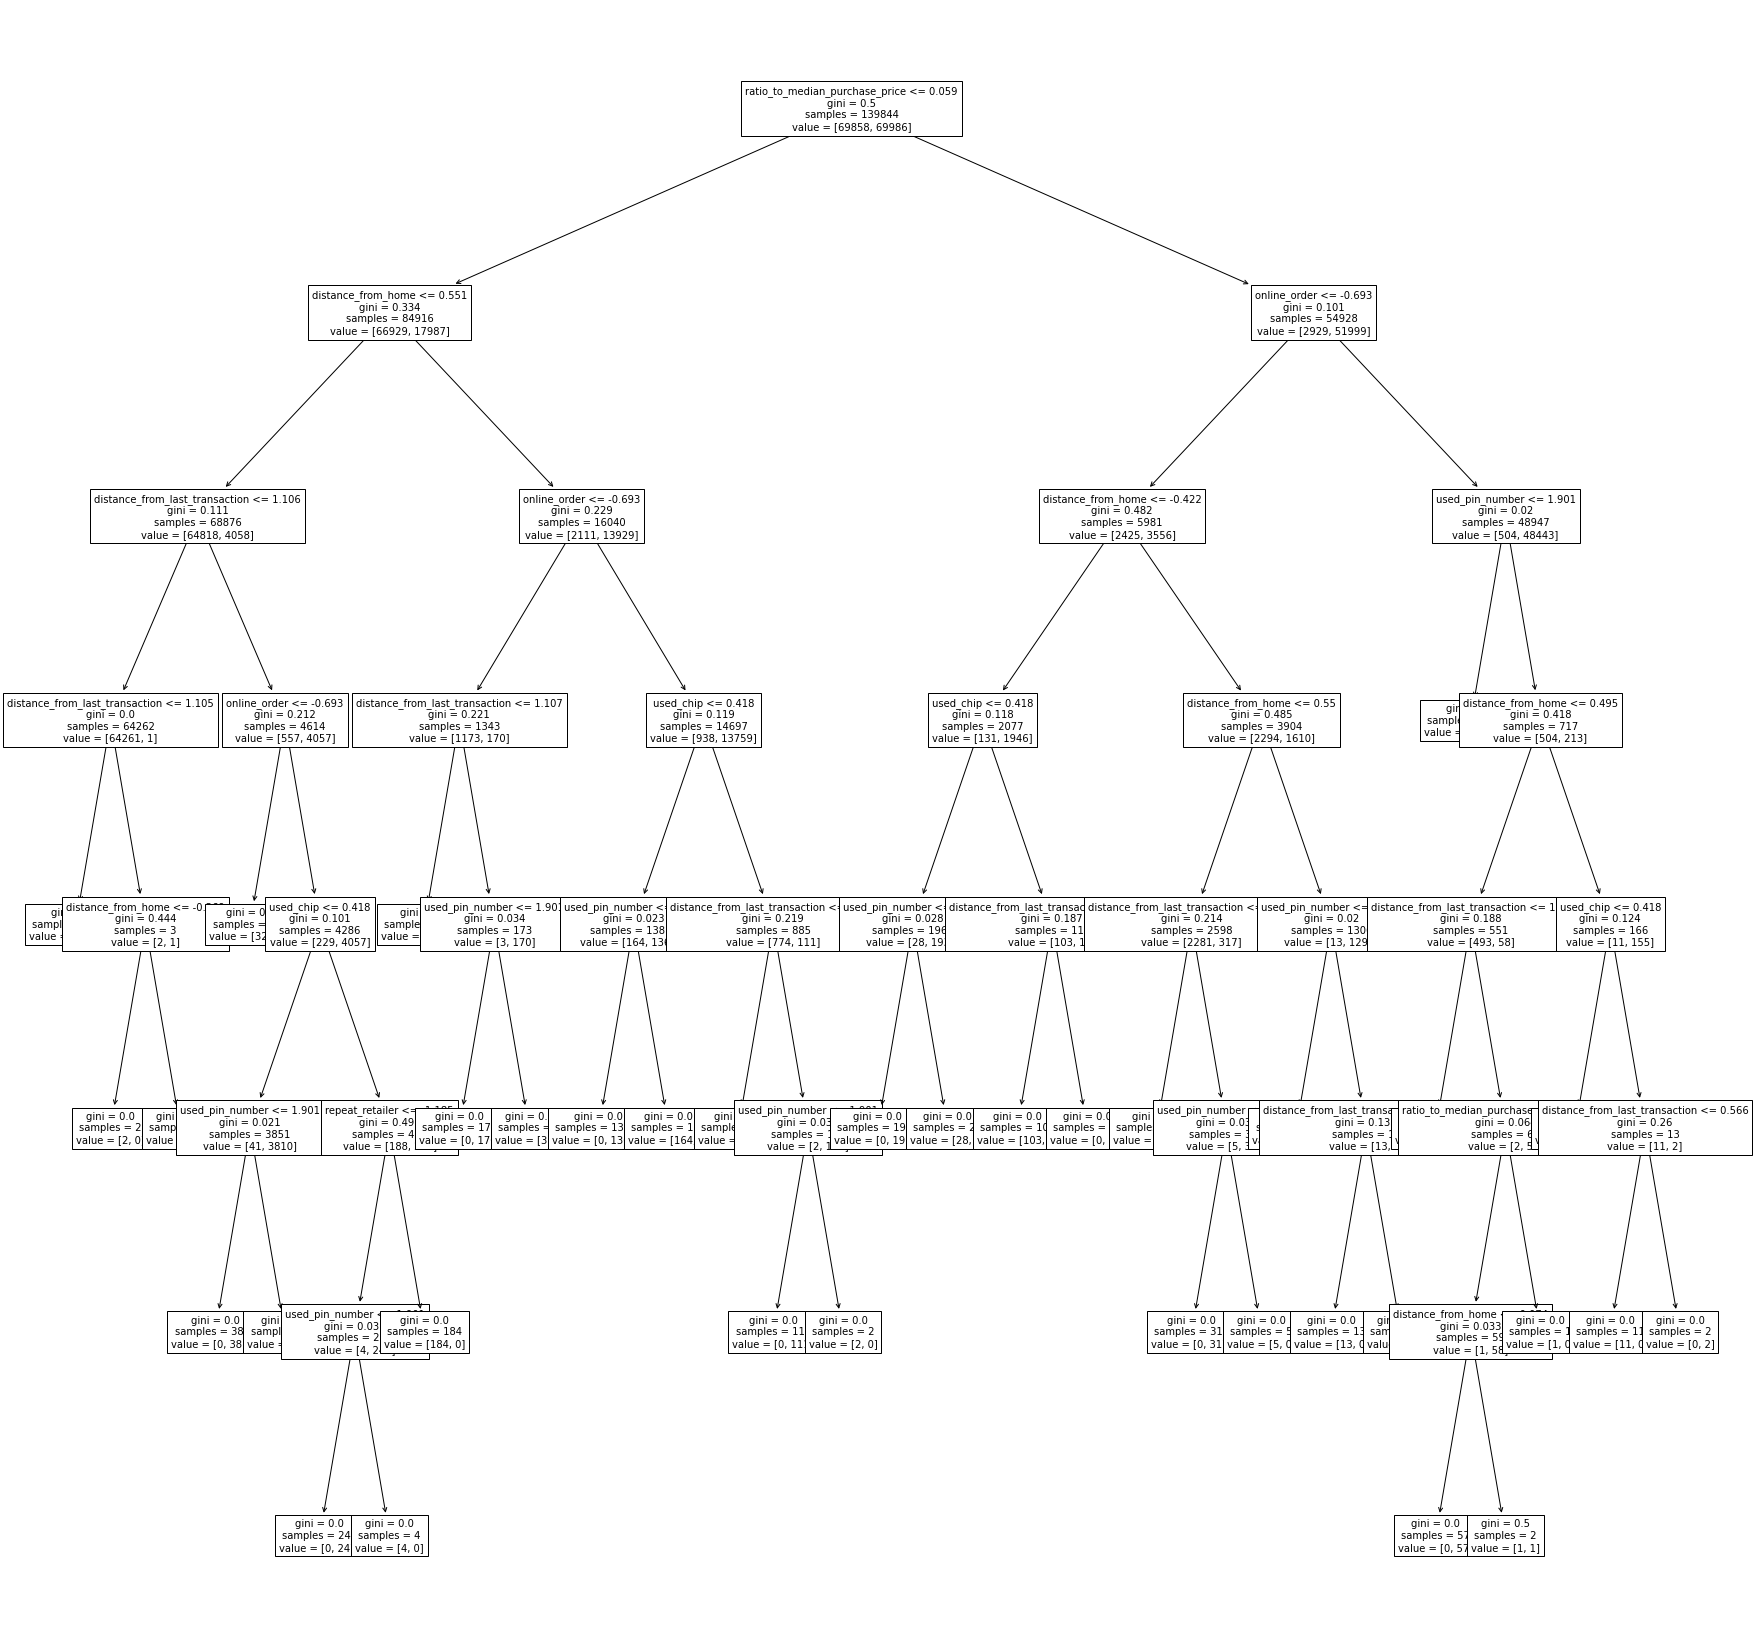

In [23]:
model_func(CustomNormalizer.standardize(x_train), CustomNormalizer.standardize(x_test))